In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox,zscore
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_curve,classification_report
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
import re
import nltk
import string

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt
/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt


In [3]:
description = pd.read_csv('/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/description.txt')
description

,Train data:
0,ID ::: TITLE ::: GENRE ::: DESCRIPTION
1,ID ::: TITLE ::: GENRE ::: DESCRIPTION
2,ID ::: TITLE ::: GENRE ::: DESCRIPTION
3,ID ::: TITLE ::: GENRE ::: DESCRIPTION
4,Test data:
5,ID ::: TITLE ::: DESCRIPTION
6,ID ::: TITLE ::: DESCRIPTION
7,ID ::: TITLE ::: DESCRIPTION
8,ID ::: TITLE ::: DESCRIPTION
9,Source:


- The train data has columns; ID,TITLE,GENRE,DESCRIPTION which are separated by ::: and the test data doesn't have the genre rest in same format as that is the label. Lets load the file according to this format.

In [4]:
# Load the training data 
train_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt"
train = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
train

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


- Load the test data

In [5]:
test_path = "/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt"
test = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test.head(4)

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."


In [6]:
# Check the shape 
train.shape

(54214, 3)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


- The output shows the list of variables, sizes, if it contains missing values and data type for each variable. From the dataset, we don’t have any missing values and we have all the  3 features having the object datatype.

In [8]:
# As shown in the above cell there are no missing values
train.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [9]:
# Checking for duplicates
train.duplicated().sum()

0

In [10]:
#Checking for descriptive statistics
train.describe(include = "object").T

,count,unique,top,freq
Title,54214,54214,Oscar et la dame rose (2009),1
Genre,54214,27,drama,13613
Description,54214,54086,Grammy - music award of the American academy ...,12


# Visualization

In [11]:
# check unique values in dataset
train.apply(lambda x: len(x.unique()))

Title          54214
Genre             27
Description    54086
dtype: int64

In [12]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))
# Function to clean description
def clean_description(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text) # remove urls
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english') 
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()
    return text

# Apply cleaning function to Description column
train['Clean_Description'] = train['Description'].apply(clean_description)
test['Clean_Description'] = test['Description'].apply(clean_description)


# Plot genre counts

In [13]:
train['Genre'].value_counts()

Genre
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64

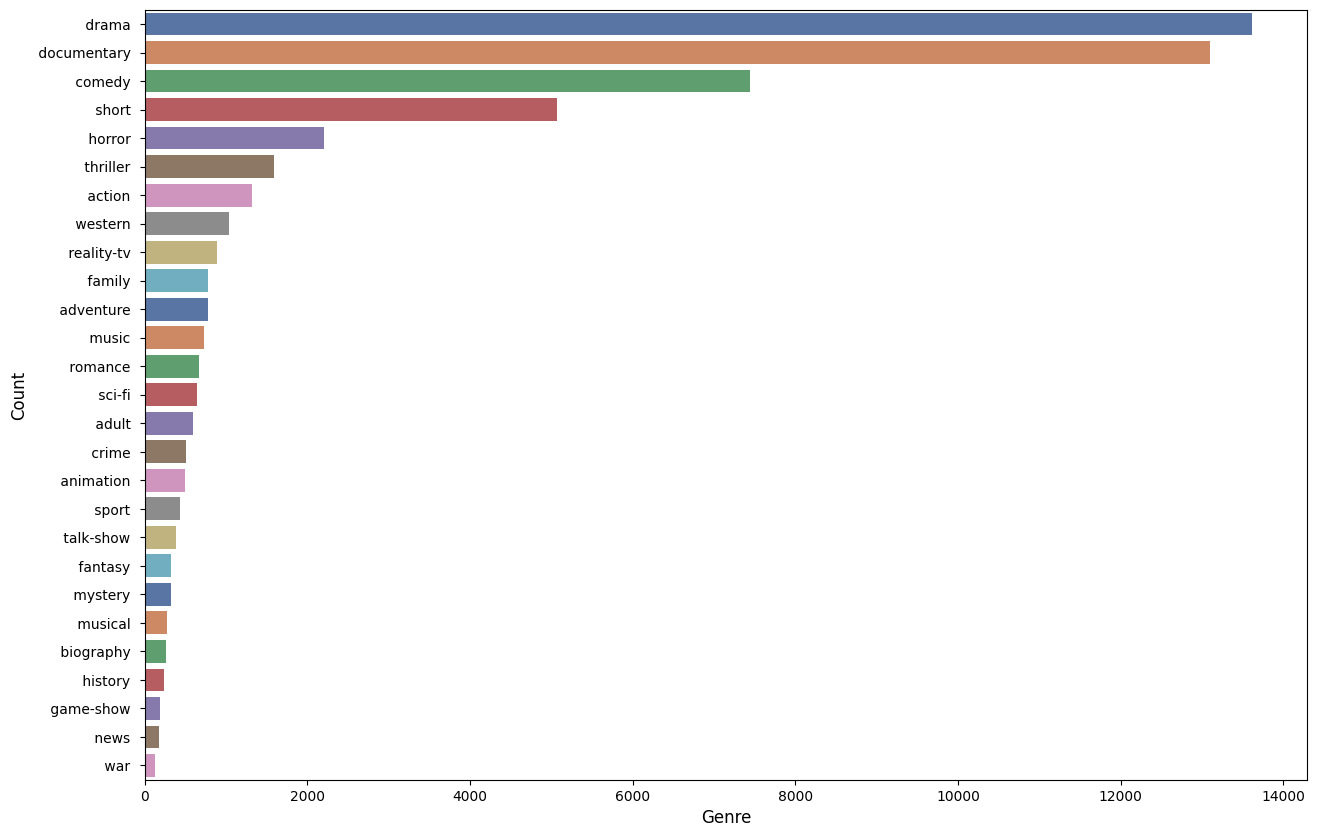

In [14]:
palette = sns.color_palette("deep")

plt.figure(figsize=(15, 10))
sns.countplot(data=train, y="Genre", order=train["Genre"].value_counts().index, palette=palette)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.show()

In [15]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = vectorizer.fit_transform(train['Clean_Description'])

# Transform the test data
X_test = vectorizer.transform(test['Clean_Description'])

In [16]:
X_train

<54214x124210 sparse matrix of type '<class 'numpy.float64'>'
	with 2640592 stored elements in Compressed Sparse Row format>

In [17]:
X_test

<54200x124210 sparse matrix of type '<class 'numpy.float64'>'
	with 2578617 stored elements in Compressed Sparse Row format>

In [18]:
X = X_train
y = train['Genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [20]:
# Make predictions on the validation set
y_pred = classifier.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_test, y_pred, zero_division=0.0))

Validation Accuracy: 0.44526422576777647
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       263
       adult        0.00      0.00      0.00       112
   adventure        0.00      0.00      0.00       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.61      0.04      0.07      1443
       crime        0.00      0.00      0.00       107
 documentary        0.54      0.90      0.67      2659
       drama        0.38      0.88      0.53      2697
      family        0.00      0.00      0.00       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.00      0.00      0.00        40
     history        0.00      0.00      0.00        45
      horror        0.00      0.00      0.00       431
       music        0.00      0.00      0.00       144
     musical        0.00      0.00      0.00        50
     mystery        0.0

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_test, y_pred, zero_division=0.0))

Validation Accuracy: 0.5808355621138062
               precision    recall  f1-score   support

      action        0.56      0.22      0.32       263
       adult        0.82      0.21      0.33       112
   adventure        0.50      0.11      0.18       139
   animation        0.67      0.02      0.04       104
   biography        0.00      0.00      0.00        61
      comedy        0.53      0.59      0.56      1443
       crime        0.50      0.01      0.02       107
 documentary        0.65      0.86      0.74      2659
       drama        0.53      0.81      0.64      2697
      family        0.50      0.05      0.09       150
     fantasy        0.00      0.00      0.00        74
   game-show        0.93      0.35      0.51        40
     history        0.00      0.00      0.00        45
      horror        0.68      0.55      0.61       431
       music        0.69      0.38      0.49       144
     musical        0.00      0.00      0.00        50
     mystery        0.00